# I.Préparation

Installation of conda and Gmpy2

In [84]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c conda-forge gmpy2

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



Import required packages

In [85]:
from gmpy2 import root, mpfr, cbrt, sqrt, c_div, is_prime, random_state, mpz_urandomb
from gmpy2 import bit_set, next_prime, bit_length, num_digits, mpz_random, gcd
from gmpy2 import invert, powmod, mpz
import time
import random
import numpy as np

# II. Fonction cryptographiques (Paillier)

Generation of prime numbers

In [86]:
def get_prime(size): # size is the binary size
    seed = random_state(time.time_ns())
    p = mpz_urandomb(seed, size)
    p = p.bit_set(size - 1)
    return next_prime(p)

Generation of Paillier public and private keys

In [87]:
def get_paillier_keys(size):
    p = get_prime(size//2)
    while True:
        q = get_prime(size//2)
        N = p*q
        phi = (p-1)*(q-1)
        if gcd(N, phi) == 1 and p != q:
            break
    g = 1 + N
    pub_key = N, g
    priv_key = phi, max(p,q), min(p,q)
    return pub_key, priv_key

Encryption and decryption functions

In [88]:
def get_r(pub_key):
    while True:
        seed = random_state(time.time_ns())
        r = mpz_random(seed, pub_key)
        if gcd(r, pub_key[0]) == 1:
            break
    return r

def paillier_encrypt(message, pub_key):
    # get random value r
    r = get_r(pub_key[0])
    # encrypt the message
    N = pub_key[0]
    g = pub_key[1]
    N2 = N ** 2
    r_pow_N = powmod(r, N, N2)
    g_pow_m = powmod(g, message, N2)
    c = (g_pow_m * r_pow_N) % N2
    return c

def paillier_decrypt(enc, priv_key, pub_key):
    N = pub_key
    phi = priv_key
    N2 = N ** 2

    # Calculate L(u) = (u-1)/N
    # First, compute c^phi mod N^2
    c_pow_phi = powmod(enc, phi, N2)

    # Apply L function: L(u) = (u-1)/N
    L_result = (c_pow_phi - 1) // N

    # Calculate mu = phi^(-1) mod N
    mu = invert(phi, N)

    # Calculate message: m = L(c^phi mod N^2) * mu mod N
    m = (L_result * mu) % N
    return m

def paillier_decrypt_CRT(enc, priv_key, pub_key):
    phi = priv_key[0]
    p = priv_key[1]
    q = priv_key[2]
    N = pub_key[0]

    # Compute modular exponentiation with CRT
    xp = powmod(enc, phi, p**2)
    xq = powmod(enc, phi, q**2)

    # Compute modular inverse of q^2 with respect to p^2
    Invq = invert(q**2, p**2)

    # Apply CRT to find x = c^phi mod N^2
    x = ((Invq*(xp-xq)) % p**2)*q**2 + xq

    # Apply L function and complete decryption
    L_result = (x-1)//N
    m = (L_result * invert(phi, N)) % N
    return m

# III. Fonctions de transformation : image / liste 2D / vecteur 1D

Fonctions pour applattir l'image en un vecteur et reconstruire l'image à partir du vecteur

In [89]:
def image_flattening(image):
    """
    Convertit l'image en un vecteur 1D et la divise en blocs.
    """
    h, w = image.shape
    vectorized_image = image.flatten()
    return vectorized_image, (h, w)

def image_reconstruction(vector, shape):
    """
    Reconstruit l'image à partir du vecteur.
    """
    return vector.reshape(shape)

Test pour charger une image (et l'afficher), la transformer en vecteur (et afficher ce vecteur), puis re-transformer le vecteur en image (et afficher l'image)

Taille de l'image choisie : (107, 150) 

L'image de départ :


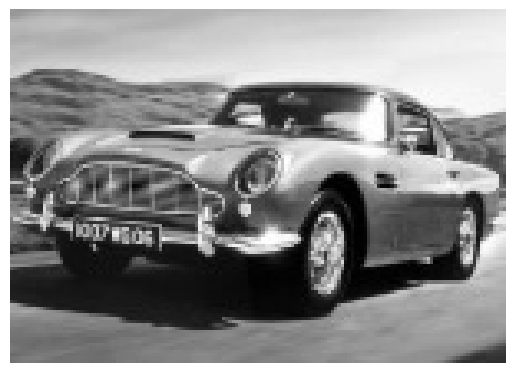


Vecteur tronqué : [152 151 150 150 151 153 156 157 159 162]  de taille : 16050 

L'image reconstituée à partir du vecteur


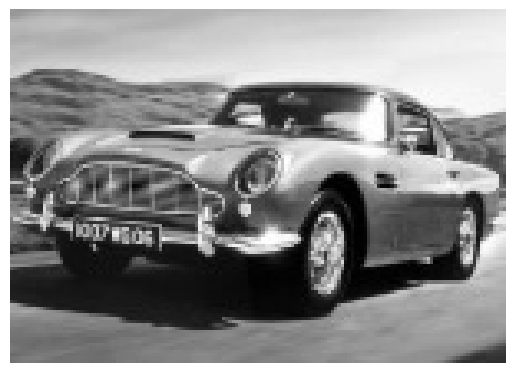

In [90]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger l'image en niveaux de gris
image = cv2.imread("image_aston.jpg", cv2.IMREAD_GRAYSCALE)

# Afficher la forme de l’image (hauteur, largeur)
print("Taille de l'image choisie :", image.shape, "\n")

# Afficher l'image avec Matplotlib
print("L'image de départ :")
plt.imshow(image, cmap="gray")
plt.axis("off")  # Supprime les axes
plt.show()

# Transformation en vecteur
vector, shape = image_flattening(image)
print("\nVecteur tronqué :", vector[:min(10, len(vector))], " de taille :", len(vector), "\n")

# Reconstruction de l'image
reconstructed_image = image_reconstruction(vector, shape)

# Afficher l'image avec Matplotlib
print("L'image reconstituée à partir du vecteur")
plt.imshow(reconstructed_image, cmap="gray")
plt.axis("off")  # Supprime les axes
plt.show()


# IV. Pre-marque

Fonctions qui permettent l'insertion de la pré-marque dans le vecteur représentant l'image

In [91]:
import numpy as np

def divide_into_blocs(vector, s):
    """
    Divise un vecteur en blocs de taille s.
    """
    if len(vector) % s == 0:
        return vector.reshape(-1, s)  # Retourne un tableau numpy (matrice)
    else:
        return np.array([vector[i:i+s] for i in range(0, len(vector), s)], dtype=object)  # Objet pour gérer tailles différentes

def quantization_index_modulation(m, delta, b):
    """
    Implémente la QIM pour tatouer un bit b dans le message m avec un pas de quantification delta.
    """
    if np.floor(m / delta) == 255 and b == 0:
        return (np.floor(m / delta) * delta) - 1
    elif np.floor(m / delta) % 2 == b:
        return (np.floor(m / delta) * delta)
    else:
        return (np.floor(m / delta) * delta) + delta

def insert_premark_block(block, pre_mark, delta = 1):
    """
    Insère une pré-marque dans les blocs à l'aide de QIM.
    """
    pre_marked_block = []
    for pixel_index in range(len(block)):
        pixel = block[pixel_index]
        pre_mark_bit = pre_mark[pixel_index]
        result_QIM = int(quantization_index_modulation(pixel, delta, pre_mark_bit))
        pre_marked_block.append(result_QIM)
    return np.array(pre_marked_block)

def insert_premark(vector, s):
    """
    Divise un vecteur en blocs de taille s
    Dasn chaque bloc, insère une pré-marque à l'aide de QIM.
    Retourne le vecteur dont les blocs ont été pré-marqués
    """
    pre_mark = np.random.randint(0, 2, s)  # Génère une pré-marque aléatoire (0 ou 1) de taille s
    blocks = divide_into_blocs(vector, s) # Blocs de taille s
    pre_marked_vector = []
    for block in blocks:
        pre_marked_block = insert_premark_block(block, pre_mark)
        pre_marked_vector.extend(pre_marked_block)
    return np.array(pre_marked_vector), pre_mark


Ajout de la pré-marque dans notre image

In [92]:
s = 256  # Taille des blocs

pre_marked_vector, pre_mark = insert_premark(vector, s)

print("\nVecteur tronqué représentant l'image :\n", vector[:min(10, len(vector))])
print("\nVecteur représentant l'image pré-marquée :\n", pre_marked_vector[:min(10, len(pre_marked_vector))])



Vecteur tronqué représentant l'image :
 [152 151 150 150 151 153 156 157 159 162]

Vecteur représentant l'image pré-marquée :
 [152 152 151 150 151 153 156 157 160 163]


#V. Chiffrement de l'image

Fonction pour chiffrer l'image (en utilisant les fonctions cryptographiques de Paillier de la partie "II. Fonction cryptographiques")

In [93]:
def encrypt_vector(vector, public_key):
    """
    Chiffrement homomorphe du vecteur d'image avec le cryptosystème de Paillier.
    """
    encrypted_vector = []
    for pixel in vector:
      encrypted_vector.append(paillier_encrypt(mpz(pixel), public_key))
    return np.array(encrypted_vector)

In [94]:
def decrypt_vector(vector, public_key, private_key):
    """
    Chiffrement homomorphe du vecteur d'image avec le cryptosystème de Paillier.
    """
    decrypted_vector = []
    for pixel in vector:
      decrypted_vector.append(paillier_decrypt_CRT(pixel, private_key, public_key))
    return np.array(decrypted_vector)

Génération des clés de chiffrement et chiffrement du vecteur représentant l'image

In [95]:
# Taille des clés
size = 512

# Génération des clés publiques et privées utilisées dans la suite
public_key, private_key = get_paillier_keys(size)

# Chiffrement du vecteur pré-marqué
encrypted_vector = encrypt_vector(pre_marked_vector, public_key)

# Affichage du vecteur chiffré
print("Vecteur chiffré tronqué:\n", encrypted_vector[:min(5, len(encrypted_vector))])

Vecteur chiffré tronqué:
 [mpz(25748827677014089898613455665369385513376996862022970666888233111781786691705321809375544708179951838256989150658436148616977121256025381379505560481798768167534820957546505498025093318167783560650453672114718943936162650486915733622612458790854947154027742410612419808347877529937012424197256374615016896567)
 mpz(21386831968810801590582909629369791253614180184601199532664382538098579716612526876014656507351156981245379544253421575905633970795482720850392994778285466707560091666711516029353727749378781327468881054804134814928077603704399456436291053225248146218878768233458548847156759042879406356740123711632522421211)
 mpz(59941117601310359670858062759686686060051510705638402671065376545455058820527029573673594559182243653722962234144478605153736559770187540027300442891575235922776710941929749571021005136522775207297191811721646190079025463766981111699448377357105517964233455617998281228673208842654948722213946664988649403176)
 mpz(119586246928077388801912

#VI. Transformation : message en texte / message en bits

Fonctions pour transformer un texte en liste de bits, et une liste de bits en texte

In [96]:
def string_to_bits(message):
    """
    Convertit une chaîne de caractères en une liste de bits individuels.

    :param message: str, le message à convertir
    :return: list, liste de bits (0 et 1)
    """
    return [int(bit) for char in message for bit in format(ord(char), '08b')]

def bits_to_string(bits):
    """
    Convertit une liste de bits individuels en une chaîne de caractères.

    :param bits: list, liste de bits (0 et 1)
    :return: str, le message reconstruit
    """
    return ''.join(chr(int(''.join(map(str, bits[i:i+8])), 2)) for i in range(0, len(bits), 8))


Utilisation des message "James Bond est un agent secret" et "Aston Martin" qu'on va tatouer dans l'image. Pour cela il faut le transformer en bits.

In [97]:
# Messages à utiliser

message1 = "James Bond est un agent secret"
print("Message original pour le domaine clair:", message1)

message2 = "Aston Martin"
print("Message original pour le domaine chiffré:", message2)


# Transformation en bits

message_bits1 = string_to_bits(message1)
print("\nListe des bits pour le domaine clair :", message_bits1)
print("     longueur du message en bits (max 256 bits car c'est la taille des blocs) :", len(message_bits1))

message_bits2 = string_to_bits(message2)
print("Liste des bits pour le domaine chiffré :", message_bits2)
print("     longueur du message en bits (max 256 bits car c'est la taille des blocs) :", len(message_bits2))


# Re-transformation en texte

reconstructed_message1 = bits_to_string(message_bits1)
print("\nMessage reconstruit pour le domaine clair:", reconstructed_message1)

reconstructed_message2 = bits_to_string(message_bits2)
print("Message reconstruit pour le domaine chiffré:", reconstructed_message2)

Message original pour le domaine clair: James Bond est un agent secret
Message original pour le domaine chiffré: Aston Martin

Liste des bits pour le domaine clair : [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0]
     longueur du message en bits (max 256 bits car c'est la taille des blocs) : 240
Liste des bits pour le domain

# VII. Insertion d'un message dans le domaine clair de l'image

Fonction pour insérer et extraire un message (liste de bits) dans le domaine clair de l'image, à partir du vecteur chiffré représentant l'image

In [98]:
def insertion_clair(vector, message, public_key):
    """
    Insertion de la marque dans le domaine clair en utilisant le cryptosystème de Paillier.
    """

    # Ajustement du message à la taille de la pre_marque : 256 bits
    if len(message) < 256:
        message.extend([0] * (256 - len(message)))  # Remplissage avec des 0
    else:
        message = message[:256]  # Tronquage

    # Chiffrer les éléments du message
    encrypted_message = [paillier_encrypt(bit, public_key) for bit in message]

    encrypted_message_repete = (encrypted_message * (len(vector) // len(encrypted_message) + 1))[:len(vector)]  # Duplique puis tronque à `len(vector)` éléments

    # Multiplication élément par élément
    result_vector = np.array([enc_v * enc_l for enc_v, enc_l in zip(vector, encrypted_message_repete)])

    return result_vector

def detect_clair_message(encrypted_vector, pre_mark):
    """
    Détection de la marque dans le domaine clair en appliquant modulo 2 sur les valeurs chiffrées.
    pre_mark est de la même taille que le message
    """
    decrypted_vector = decrypt_vector(encrypted_vector, public_key, private_key)

    # Rem : On a decrypted_vector%2 = vector_premarqué%2 + b et on a fait en sorte (pré-marquage) que vector_premarqué%2 = pre_marque
    # Reme : Donc b = decrypted_vector%2 - pre_marque

    message_detected = []
    for pixel_index in range(len(decrypted_vector)):
        pixel = decrypted_vector[pixel_index]
        pre_mark_bit = pre_mark[pixel_index%256]
        bit_message = abs(pixel%2 - pre_mark_bit)
        message_detected.append(int(bit_message))

    return message_detected

Insertion du message dans le domaine clair de l'image à partir du vecteur chiffré représentant l'image, et test de l'extraction du message

In [99]:
# Insertion du message
image_encryptee_avec_message_dans_le_clair = insertion_clair(encrypted_vector, message_bits1, public_key)
print("Insertion effectuée\n")

# Extraction du message
message_clair_detected = detect_clair_message(image_encryptee_avec_message_dans_le_clair, pre_mark)
print("Message (bits) detecté tronqué:", message_clair_detected[:min(10, len(message_clair_detected))])

# Reconstruction du message textuel (grâce aux fonction de la partie "VI. Transformation : message en texte / message en bits")
message_clair_detected = message_clair_detected[:256] # On ne prend que le premier bloc (puisqu'on a tatoué le même message dans chaque bloc)
reconstructed_message_clair = bits_to_string(message_clair_detected)
print("\nMessage détecté dans le domaine clair de l'image :", reconstructed_message_clair)

Insertion effectuée

Message (bits) detecté tronqué: [0, 1, 0, 0, 1, 0, 1, 0, 0, 1]

Message détecté dans le domaine clair de l'image : James Bond est un agent secret  


#VIII. Insertion d'un message dans le domaine chiffré de l'image

Fonction pour insérer et extraire un message (liste de bits) dans le domaine chiffré de l'image, à partir du vecteur chiffré représentant l'image

In [100]:
def insertion_chiffre_pixel(encrypted_pixel, b_message, public_key):
    """
    Insère un bit dans un pixel chiffré en forçant `mod 2 == b_message`
    """
    while encrypted_pixel % 2 != b_message:
        encrypted_pixel = (encrypted_pixel * paillier_encrypt(0, public_key)) % (public_key[0]**2)
    return encrypted_pixel

def insertion_chiffre(vector_clair, b_message, public_key):
    b_message_repete = b_message + [0] * (len(vector_clair) - len(b_message)) # Complète le message avec suffisement de 0
    vector_chiffre = [insertion_chiffre_pixel(pixel, bit, public_key)
                      for pixel, bit in zip(vector_clair, b_message_repete)]
    return np.array(vector_chiffre)

def extraction_chiffre_pixel(encrypted_pixel):
    """
    Extrait un bit caché dans un pixel chiffré.
    """
    return encrypted_pixel % 2

def extraction_chiffre(vector_chiffre):
    """
    Extrait un message entier caché dans un vecteur chiffré.
    """
    return np.array([extraction_chiffre_pixel(pixel) for pixel in vector_chiffre])

Insertion du message dans le domaine chiffré de l'image à partir du vecteur chiffré représentant l'image (dans lequel a déjà été inséré le message dans le domaine clair), et test de l'extraction du message

In [101]:
# Insertion du message
image_encryptee_avec_message_dans_le_chiffre = insertion_chiffre(image_encryptee_avec_message_dans_le_clair, message_bits2, public_key)
print("Insertion effectuée\n")

# Extraction du message
b_extracted = extraction_chiffre(image_encryptee_avec_message_dans_le_chiffre)

# Reconstruction du message textuel (grâce aux fonction de la partie "VI. Transformation : message en texte / message en bits")
bits_list = [int(x) for x in b_extracted]# Conversion de la liste de "mpz" en liste de int
print("Message (bits) detecté tronqué:", bits_list[:min(10, len(bits_list))])
message_extrait = bits_to_string(bits_list).rstrip('\x00') # Suppression les caractères nuls qui sont dus au fait que le message est trop court par rapport à l'image
print("\nMessage extrait dans le domaine chiffré de l'image :", message_extrait)


Insertion effectuée

Message (bits) detecté tronqué: [0, 1, 0, 0, 0, 0, 0, 1, 0, 1]

Message extrait dans le domaine chiffré de l'image : Aston Martin


#IX. Exctraction du message en clair, après avoir ajouté le tatouage dans le domaine chiffré

On extrait le message tatoué dans le domaine clair (après avoir tatoué le message du domaine chiffré)

In [102]:
# Extraction du message
message_clair_detected_v2 = detect_clair_message(image_encryptee_avec_message_dans_le_chiffre, pre_mark)
print("Message (bits) detecté tronqué:", message_clair_detected_v2[:min(10, len(message_clair_detected_v2))])

# Reconstruction du message textuel (grâce aux fonction de la partie "VI. Transformation : message en texte / message en bits")
message_clair_detected_v2 = message_clair_detected_v2[:256] # On ne prend que le premier bloc (puisqu'on a tatoué le même message dans chaque bloc)
reconstructed_message_clair_v2 = bits_to_string(message_clair_detected_v2)
print("\nMessage détecté dans le domaine clair de l'image :", reconstructed_message_clair_v2)

Message (bits) detecté tronqué: [0, 1, 0, 0, 1, 0, 1, 0, 0, 1]

Message détecté dans le domaine clair de l'image : James Bond est un agent secret  


#X. Bonus : Reconstruction de l'image, à partir du vecteur tatoué

Visualisation de l'image tatouée à partir du vecteur, dans lequel ont été insérée les tatouages dans le domaine clair et le domaine chiffré

L'image qui contient les tatouages dans le domaine clair et le domaine chiffré :


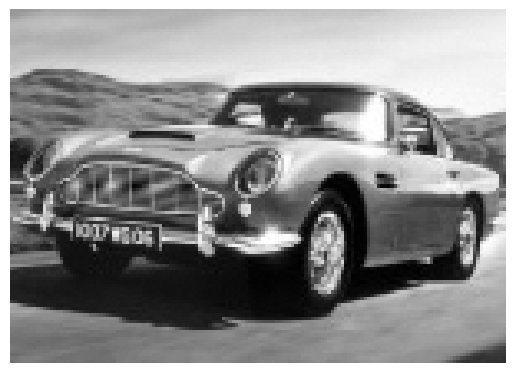

In [103]:
# Déchiffrer (Partie "V. Chiffrement de l'image") l'image dans laquelle les messages ont été ajoutés dans le domaine clair puis dans le domaine chiffré
image_decryptee_avec_message_dans_le_chiffre = decrypt_vector(image_encryptee_avec_message_dans_le_chiffre, public_key, private_key)

# Reconstruction de l'image (mpz en int PUIS vecteur 1D en list 2D PUIS list 2D -> image)
image_decryptee_avec_message_dans_le_chiffre = np.array([int(x) for x in image_decryptee_avec_message_dans_le_chiffre])
watemarked_image = image_reconstruction(image_decryptee_avec_message_dans_le_chiffre, shape)

# Afficher l'image avec Matplotlib
print("L'image qui contient les tatouages dans le domaine clair et le domaine chiffré :")
plt.imshow(watemarked_image, cmap="gray")
plt.axis("off")  # Supprime les axes
plt.show()
